In [1]:
import sys
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import gym

from collections import deque

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD

C:\Users\Saeed\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Saeed\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Saeed\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Saeed\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
# *******************************************************************************************
# Random seeds for reproducibility

# _seeds = np.random.randint(low = 0, high = 100, size = (3, 4))
# print(_seeds)

# Produced seeds:
# [[87 32 19 47]
#  [69 92  6 65]
#  [36 84 36 44]]

In [3]:
# *******************************************************************************************
# Environment Initialization

env = gym.make('CartPole-v0')

random.seed(87)
np.random.seed(32)
tf.set_random_seed(19)
env.seed(47)

state_size  = env.observation_space.shape[0]
action_size = env.action_space.n

print("Obseravtion spapce size: {}".format(state_size))
print("Action space size: {}".format(action_size))

C:\Users\Saeed\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Obseravtion spapce size: 4
Action space size: 2


In [4]:
# *******************************************************************************************
# Algorithm Parameters

n_episodes     = 5000
batch_size     = 32
total_steps    = 1e6
print_interval = 1

In [5]:
# *******************************************************************************************
# CLASS

class Agent:  
    def __init__(self, state_size, action_size):
        
# ********************************
# Parameters 

        self.state_size    = state_size
        self.action_size   = action_size
        self.counter       = 0
        self.eval_interval = 200
        self.epsilon       = 1.0
        self.epsilon_min   = 0.01
        self.epsilon_decay = 0.99
        self.learning_rate = 0.001
        self.alpha         = 0.002     

        self.loss1         = list()
        self.loss2         = list()
        self.loss_reverse1 = list()
        self.loss_reverse2 = list()
        
        
        self.reverse_horizon  = 4
        self.aug_traj_count   = 4
        self.initial_steps    = 0
        self.total_back_steps = 2
        
#  Optimized hyper parameters        
#         self.reverse_horizon  = 4
#         self.aug_traj_count   = 1
#         self.initial_steps    = 10
#         self.total_back_steps = 2
#         self.alpha         = 0.01     


        
        
# ********************************
# Memories

        self.memory_tape = deque(maxlen=20000)
        self.memory_full = deque(maxlen=None)
        self.state_memory = deque(maxlen=20000)
        self.memory_episode = deque(maxlen=200)    
        self.horizon = deque (maxlen = self.reverse_horizon)
#         self.augmented_reverse_horizon = deque (maxlen = self.reverse_horizon)

        self.reward_string = self.build_reward_string()
#         plt.plot(self.reward_string) # This is to plot the credit assignment string
#         plt.show()

# ********************************
# Models

        self.model         = self.build_model()
        self.model_eval    = self.build_network_eval()
        self.model_reverse = self.build_model()

# *******************************************************************************************
# FUNCTIONS

# ********************************
# Neural Networks

    def build_network(self):
        nn = Sequential()
        nn.add(Dense(16, input_dim = state_size , activation='relu'))
        nn.add(Dense(16, activation='relu'))
        nn.add(Dense( state_size , activation='linear'))
        nn.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return nn
    
    def build_model(self):
        model = list()
        for i in range(action_size):
            model.append(self.build_network())
        return model
    
    def build_network_eval(self):
        nn = Sequential()
        nn.add(Dense(16, input_dim = state_size , activation='relu'))
        nn.add(Dense(16, activation='relu'))
        nn.add(Dense( 1 , activation='linear'))
        nn.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return nn

# ********************************
# Replay Buffer

    def remember_tape(self, state, action, next_state):
        self.memory_tape.append((state, action, next_state)) 
        self.horizon.append((state, action))
              
    def remember_episode(self, state, action, next_state):
        self.memory_episode.append((state, action, next_state)) 
        
# ********************************
# Policy

    def act(self, state):
#         TODO: This is manual now,
#         instead of two separate networks, a network and output of action_size should be used
        if np.random.rand() <= self.epsilon:
            act = np.random.randint(self.action_size)
            return act
        
        self.future = list()
        evaluated   = list()
        state       = np.reshape(state, [1,state_size])
            
        predicted_state0 = self.model[0].predict(state)
        predicted_state1 = self.model[1].predict(state)
        eval_state0 = self.evaluate_state(predicted_state0)        
        eval_state1 = self.evaluate_state(predicted_state1)
        evaluated = [eval_state0 , eval_state1]
        
        if eval_state0 == eval_state1:               
            act = np.random.randint(2)
            return act
        
        act = np.argmin(evaluated)
        return act
  
    def evaluate_state(self,state):
        eval = self.model_eval.predict(state)
        return eval
    
# ********************************
# Models   
    def train(self):
        
        minibatch = random.sample(self.memory_tape, min(len(agent.memory_tape),batch_size))
        
        for state, action, next_state in minibatch:
            state = np.reshape(state, [1,state_size])
            next_state = np.reshape(next_state, [1, state_size]) 
            
            self.model[action].fit(state, next_state, epochs=1, verbose=0)
            self.model_reverse[action].fit(next_state, state, epochs=1, verbose=0)
            
        if (self.counter % self.eval_interval == 0):
            eval_score = self.model[action].evaluate(state, next_state, verbose=1,steps=1)
            eval_score_reverse = self.model_reverse[action].evaluate(state, next_state, verbose=1,steps=1)
            
            if action ==0:
                self.loss1.append(eval_score)
                self.loss_reverse1.append(eval_score_reverse)

            else:
                self.loss2.append(eval_score)
                self.loss_reverse2.append(eval_score_reverse)

        self.counter += 1
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def eval_train(self):
#         TODO: Datasets should be combined before learning(fitting)
#         if (self.counter > self.initial_steps):
        
#             self.augment_samples()
    
  
            
       
        boundary = np.reshape (agent.horizon,[4, 2])
        
        boundary = np.concatenate((boundary, self.reward_string), axis = 1)
        
        for state, i, reward in boundary:
            
            state  = np.reshape(state, [1,state_size])
            
            reward = self.model_eval.predict(state) * (1-self.alpha) + reward * self.alpha
            
            self.model_eval.fit(state, reward, epochs=1, verbose=0)
        
        temp   = self.memory_episode
    
        lenght = len(temp)
        
        temp   = np.reshape(temp, [lenght,3])
        
        temp   = tuple(temp[:-4])
        
        temp   = random.sample(temp, 4)
        
        for state, action, next_state in temp:
            
            state  = np.reshape(state, [1,state_size])
            
            reward = self.model_eval.predict(state) * (1-self.alpha)
            
            self.model_eval.fit(state, reward, epochs=1, verbose=0) 
            
    def build_reward_string(self):
#         TODO: This is manual now, It is a parameter that should be evaluated
        return np.reshape(np.array([0.25, 0.5, 0.75, 1]),[4,1])

    def augment_samples(self):
        
        credit = self.build_reward_string()
        
        last_state = self.horizon[-1][0] 
               
        for _trajectory in range(self.aug_traj_count):
            
            current_state = last_state
            
            for backward_step in range(self.total_back_steps):
                
                random_reverse_action = np.random.randint(self.action_size)
                
                current_state  = np.reshape(current_state, [1,state_size])
                
                past_state = self.model_reverse[random_reverse_action].predict(current_state)
                
                reward = self.model_eval.predict(past_state) * (1-self.alpha) + credit[-backward_step-2] * self.alpha
                
                self.model_eval.fit(past_state, reward, epochs=1, verbose=0)
                
                current_state = past_state
                

In [6]:
# *******************************************************************************************
# Main 

agent  = Agent(state_size, action_size)

_steps = 0
done   = False
score  = list()

cons_success    = 0
done_in         = n_episodes
render_interval = 25
state_full      = list()

for e in range(n_episodes):
    
    state_episode = np.zeros((1,4))
    state = env.reset()
    agent.state_memory.clear()
    
    for time in range(200):
        
#       if e % render_interval ==0: 
#         env.render(mode="human") 

        action = agent.act(state)
        state_episode = np.concatenate ((state_episode , (np.reshape(state,(1,4)))),axis=0)
        next_state, reward, done, _ = env.step(action)
        _steps += 1
        
        if _steps >= total_steps:
            print("total steps of {} reached".format(total_steps))
            sys.exit()
            
        agent.remember_tape(state, action, next_state)
        agent.remember_episode(state, action, next_state)



        agent.state_memory.append(state)   
        state = next_state
        
        if done:
            if (e % print_interval) == 0:
                print("episode: {}/{}, score: {}, e: {:.2}, total steps: {}".format(e, n_episodes, time, agent.epsilon,_steps))
            
            state_full.append(state_episode)
            
            score.append(time)
            np.savetxt('bk_linear_H4_1.out', score, delimiter=',')
            np.savetxt('bk_linear_H4_1.out', score, fmt='%d')
            
            # to record 100 consecutive success
            if ((len(agent.state_memory)) >= 195):
                consecutive_success += 1
            else:
                consecutive_success = 0
            if consecutive_success == 100:
                done_in = e
                print ("Done in:", done_in-100, "Epidodes -------------------------------------------------------" )
                
            
            
            if ((len(agent.state_memory)) < 198) and ((len(agent.state_memory)) > 2*agent.reverse_horizon):
                agent.eval_train()

#             if len(agent.memory_tape) > batch_size:
            agent.train()
            
            break
            
    agent.state_memory.clear()
    agent.memory_episode.clear()

W0331 09:22:13.842646 17480 deprecation_wrapper.py:119] From C:\Users\Saeed\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0331 09:22:13.886528 17480 deprecation_wrapper.py:119] From C:\Users\Saeed\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0331 09:22:13.919440 17480 deprecation_wrapper.py:119] From C:\Users\Saeed\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0331 09:22:14.038124 17480 deprecation_wrapper.py:119] From C:\Users\Saeed\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0331 09:22:14.395169 17480 deprecation_wrapper.py:119] From C:\Users\Saeed\Anac

episode: 0/5000, score: 16, e: 1.0, total steps: 17
1/1 [==============================] - 0s 98ms/step
episode: 1/5000, score: 17, e: 0.99, total steps: 35
episode: 2/5000, score: 20, e: 0.98, total steps: 56
episode: 3/5000, score: 12, e: 0.97, total steps: 69
episode: 4/5000, score: 10, e: 0.96, total steps: 80
episode: 5/5000, score: 48, e: 0.95, total steps: 129
episode: 6/5000, score: 12, e: 0.94, total steps: 142
episode: 7/5000, score: 12, e: 0.93, total steps: 155
episode: 8/5000, score: 16, e: 0.92, total steps: 172
episode: 9/5000, score: 9, e: 0.91, total steps: 182
episode: 10/5000, score: 9, e: 0.9, total steps: 192
episode: 11/5000, score: 30, e: 0.9, total steps: 223
episode: 12/5000, score: 62, e: 0.89, total steps: 286
episode: 13/5000, score: 26, e: 0.88, total steps: 313
episode: 14/5000, score: 28, e: 0.87, total steps: 342
episode: 15/5000, score: 16, e: 0.86, total steps: 359
episode: 16/5000, score: 8, e: 0.85, total steps: 368
episode: 17/5000, score: 11, e: 0.

episode: 144/5000, score: 199, e: 0.24, total steps: 15207
episode: 145/5000, score: 199, e: 0.23, total steps: 15407
episode: 146/5000, score: 154, e: 0.23, total steps: 15562
episode: 147/5000, score: 199, e: 0.23, total steps: 15762
episode: 148/5000, score: 156, e: 0.23, total steps: 15919
episode: 149/5000, score: 199, e: 0.22, total steps: 16119
episode: 150/5000, score: 199, e: 0.22, total steps: 16319
episode: 151/5000, score: 199, e: 0.22, total steps: 16519
episode: 152/5000, score: 199, e: 0.22, total steps: 16719
episode: 153/5000, score: 166, e: 0.21, total steps: 16886
episode: 154/5000, score: 199, e: 0.21, total steps: 17086
episode: 155/5000, score: 199, e: 0.21, total steps: 17286
episode: 156/5000, score: 199, e: 0.21, total steps: 17486
episode: 157/5000, score: 199, e: 0.21, total steps: 17686
episode: 158/5000, score: 183, e: 0.2, total steps: 17870
episode: 159/5000, score: 199, e: 0.2, total steps: 18070
episode: 160/5000, score: 137, e: 0.2, total steps: 18208


episode: 280/5000, score: 199, e: 0.06, total steps: 42140
episode: 281/5000, score: 199, e: 0.059, total steps: 42340
episode: 282/5000, score: 199, e: 0.059, total steps: 42540
episode: 283/5000, score: 199, e: 0.058, total steps: 42740
episode: 284/5000, score: 199, e: 0.058, total steps: 42940
episode: 285/5000, score: 199, e: 0.057, total steps: 43140
episode: 286/5000, score: 199, e: 0.056, total steps: 43340
episode: 287/5000, score: 199, e: 0.056, total steps: 43540
episode: 288/5000, score: 199, e: 0.055, total steps: 43740
episode: 289/5000, score: 199, e: 0.055, total steps: 43940
episode: 290/5000, score: 199, e: 0.054, total steps: 44140
episode: 291/5000, score: 199, e: 0.054, total steps: 44340
episode: 292/5000, score: 199, e: 0.053, total steps: 44540
episode: 293/5000, score: 199, e: 0.053, total steps: 44740
episode: 294/5000, score: 199, e: 0.052, total steps: 44940
episode: 295/5000, score: 199, e: 0.052, total steps: 45140
episode: 296/5000, score: 199, e: 0.051, 

episode: 416/5000, score: 199, e: 0.015, total steps: 69340
episode: 417/5000, score: 199, e: 0.015, total steps: 69540
episode: 418/5000, score: 199, e: 0.015, total steps: 69740
episode: 419/5000, score: 199, e: 0.015, total steps: 69940
episode: 420/5000, score: 199, e: 0.015, total steps: 70140
episode: 421/5000, score: 199, e: 0.015, total steps: 70340
episode: 422/5000, score: 199, e: 0.014, total steps: 70540
episode: 423/5000, score: 199, e: 0.014, total steps: 70740
episode: 424/5000, score: 199, e: 0.014, total steps: 70940
episode: 425/5000, score: 199, e: 0.014, total steps: 71140
episode: 426/5000, score: 199, e: 0.014, total steps: 71340
episode: 427/5000, score: 199, e: 0.014, total steps: 71540
episode: 428/5000, score: 199, e: 0.014, total steps: 71740
episode: 429/5000, score: 199, e: 0.013, total steps: 71940
episode: 430/5000, score: 199, e: 0.013, total steps: 72140
episode: 431/5000, score: 199, e: 0.013, total steps: 72340
episode: 432/5000, score: 199, e: 0.013,

episode: 552/5000, score: 199, e: 0.0099, total steps: 96540
episode: 553/5000, score: 199, e: 0.0099, total steps: 96740
episode: 554/5000, score: 199, e: 0.0099, total steps: 96940
episode: 555/5000, score: 199, e: 0.0099, total steps: 97140
episode: 556/5000, score: 199, e: 0.0099, total steps: 97340
episode: 557/5000, score: 199, e: 0.0099, total steps: 97540
episode: 558/5000, score: 199, e: 0.0099, total steps: 97740
episode: 559/5000, score: 199, e: 0.0099, total steps: 97940
episode: 560/5000, score: 199, e: 0.0099, total steps: 98140
episode: 561/5000, score: 199, e: 0.0099, total steps: 98340
episode: 562/5000, score: 199, e: 0.0099, total steps: 98540
episode: 563/5000, score: 199, e: 0.0099, total steps: 98740
episode: 564/5000, score: 199, e: 0.0099, total steps: 98940
episode: 565/5000, score: 199, e: 0.0099, total steps: 99140
episode: 566/5000, score: 199, e: 0.0099, total steps: 99340
episode: 567/5000, score: 199, e: 0.0099, total steps: 99540
episode: 568/5000, score

episode: 683/5000, score: 199, e: 0.0099, total steps: 122740
episode: 684/5000, score: 199, e: 0.0099, total steps: 122940
episode: 685/5000, score: 199, e: 0.0099, total steps: 123140
episode: 686/5000, score: 199, e: 0.0099, total steps: 123340
episode: 687/5000, score: 199, e: 0.0099, total steps: 123540
episode: 688/5000, score: 199, e: 0.0099, total steps: 123740
episode: 689/5000, score: 199, e: 0.0099, total steps: 123940
episode: 690/5000, score: 199, e: 0.0099, total steps: 124140
episode: 691/5000, score: 199, e: 0.0099, total steps: 124340
episode: 692/5000, score: 199, e: 0.0099, total steps: 124540
episode: 693/5000, score: 199, e: 0.0099, total steps: 124740
episode: 694/5000, score: 199, e: 0.0099, total steps: 124940
episode: 695/5000, score: 199, e: 0.0099, total steps: 125140
episode: 696/5000, score: 199, e: 0.0099, total steps: 125340
episode: 697/5000, score: 199, e: 0.0099, total steps: 125540
episode: 698/5000, score: 199, e: 0.0099, total steps: 125740
episode:

episode: 814/5000, score: 199, e: 0.0099, total steps: 148940
episode: 815/5000, score: 199, e: 0.0099, total steps: 149140
episode: 816/5000, score: 199, e: 0.0099, total steps: 149340
episode: 817/5000, score: 199, e: 0.0099, total steps: 149540
episode: 818/5000, score: 199, e: 0.0099, total steps: 149740
episode: 819/5000, score: 199, e: 0.0099, total steps: 149940
episode: 820/5000, score: 199, e: 0.0099, total steps: 150140
episode: 821/5000, score: 199, e: 0.0099, total steps: 150340
episode: 822/5000, score: 199, e: 0.0099, total steps: 150540
episode: 823/5000, score: 199, e: 0.0099, total steps: 150740
episode: 824/5000, score: 199, e: 0.0099, total steps: 150940
episode: 825/5000, score: 199, e: 0.0099, total steps: 151140
episode: 826/5000, score: 199, e: 0.0099, total steps: 151340
episode: 827/5000, score: 199, e: 0.0099, total steps: 151540
episode: 828/5000, score: 199, e: 0.0099, total steps: 151740
episode: 829/5000, score: 199, e: 0.0099, total steps: 151940
episode:

episode: 947/5000, score: 199, e: 0.0099, total steps: 175540
episode: 948/5000, score: 199, e: 0.0099, total steps: 175740
episode: 949/5000, score: 199, e: 0.0099, total steps: 175940
episode: 950/5000, score: 199, e: 0.0099, total steps: 176140
episode: 951/5000, score: 199, e: 0.0099, total steps: 176340
episode: 952/5000, score: 199, e: 0.0099, total steps: 176540
episode: 953/5000, score: 199, e: 0.0099, total steps: 176740
episode: 954/5000, score: 199, e: 0.0099, total steps: 176940
episode: 955/5000, score: 199, e: 0.0099, total steps: 177140
episode: 956/5000, score: 199, e: 0.0099, total steps: 177340
episode: 957/5000, score: 199, e: 0.0099, total steps: 177540
episode: 958/5000, score: 199, e: 0.0099, total steps: 177740
episode: 959/5000, score: 199, e: 0.0099, total steps: 177940
episode: 960/5000, score: 199, e: 0.0099, total steps: 178140
episode: 961/5000, score: 199, e: 0.0099, total steps: 178340
episode: 962/5000, score: 199, e: 0.0099, total steps: 178540
episode:

episode: 1077/5000, score: 199, e: 0.0099, total steps: 201540
episode: 1078/5000, score: 199, e: 0.0099, total steps: 201740
episode: 1079/5000, score: 199, e: 0.0099, total steps: 201940
episode: 1080/5000, score: 199, e: 0.0099, total steps: 202140
episode: 1081/5000, score: 199, e: 0.0099, total steps: 202340
episode: 1082/5000, score: 199, e: 0.0099, total steps: 202540
episode: 1083/5000, score: 199, e: 0.0099, total steps: 202740
episode: 1084/5000, score: 199, e: 0.0099, total steps: 202940
episode: 1085/5000, score: 199, e: 0.0099, total steps: 203140
episode: 1086/5000, score: 199, e: 0.0099, total steps: 203340
episode: 1087/5000, score: 199, e: 0.0099, total steps: 203540
episode: 1088/5000, score: 199, e: 0.0099, total steps: 203740
episode: 1089/5000, score: 199, e: 0.0099, total steps: 203940
episode: 1090/5000, score: 199, e: 0.0099, total steps: 204140
episode: 1091/5000, score: 199, e: 0.0099, total steps: 204340
episode: 1092/5000, score: 199, e: 0.0099, total steps:

episode: 1206/5000, score: 199, e: 0.0099, total steps: 227340
episode: 1207/5000, score: 199, e: 0.0099, total steps: 227540
episode: 1208/5000, score: 199, e: 0.0099, total steps: 227740
episode: 1209/5000, score: 199, e: 0.0099, total steps: 227940
episode: 1210/5000, score: 199, e: 0.0099, total steps: 228140
episode: 1211/5000, score: 199, e: 0.0099, total steps: 228340
episode: 1212/5000, score: 199, e: 0.0099, total steps: 228540
episode: 1213/5000, score: 199, e: 0.0099, total steps: 228740
episode: 1214/5000, score: 199, e: 0.0099, total steps: 228940
episode: 1215/5000, score: 199, e: 0.0099, total steps: 229140
episode: 1216/5000, score: 199, e: 0.0099, total steps: 229340
episode: 1217/5000, score: 199, e: 0.0099, total steps: 229540
episode: 1218/5000, score: 199, e: 0.0099, total steps: 229740
episode: 1219/5000, score: 199, e: 0.0099, total steps: 229940
episode: 1220/5000, score: 199, e: 0.0099, total steps: 230140
episode: 1221/5000, score: 199, e: 0.0099, total steps:

episode: 1337/5000, score: 199, e: 0.0099, total steps: 253540
episode: 1338/5000, score: 199, e: 0.0099, total steps: 253740
episode: 1339/5000, score: 199, e: 0.0099, total steps: 253940
episode: 1340/5000, score: 199, e: 0.0099, total steps: 254140
episode: 1341/5000, score: 199, e: 0.0099, total steps: 254340
episode: 1342/5000, score: 199, e: 0.0099, total steps: 254540
episode: 1343/5000, score: 199, e: 0.0099, total steps: 254740
episode: 1344/5000, score: 199, e: 0.0099, total steps: 254940
episode: 1345/5000, score: 199, e: 0.0099, total steps: 255140
episode: 1346/5000, score: 199, e: 0.0099, total steps: 255340
episode: 1347/5000, score: 199, e: 0.0099, total steps: 255540
episode: 1348/5000, score: 199, e: 0.0099, total steps: 255740
episode: 1349/5000, score: 199, e: 0.0099, total steps: 255940
episode: 1350/5000, score: 199, e: 0.0099, total steps: 256140
episode: 1351/5000, score: 199, e: 0.0099, total steps: 256340
episode: 1352/5000, score: 199, e: 0.0099, total steps:

episode: 1466/5000, score: 199, e: 0.0099, total steps: 279340
episode: 1467/5000, score: 199, e: 0.0099, total steps: 279540
episode: 1468/5000, score: 199, e: 0.0099, total steps: 279740
episode: 1469/5000, score: 199, e: 0.0099, total steps: 279940
episode: 1470/5000, score: 199, e: 0.0099, total steps: 280140
episode: 1471/5000, score: 199, e: 0.0099, total steps: 280340
episode: 1472/5000, score: 199, e: 0.0099, total steps: 280540
episode: 1473/5000, score: 199, e: 0.0099, total steps: 280740
episode: 1474/5000, score: 199, e: 0.0099, total steps: 280940
episode: 1475/5000, score: 199, e: 0.0099, total steps: 281140
episode: 1476/5000, score: 199, e: 0.0099, total steps: 281340
episode: 1477/5000, score: 199, e: 0.0099, total steps: 281540
episode: 1478/5000, score: 199, e: 0.0099, total steps: 281740
episode: 1479/5000, score: 199, e: 0.0099, total steps: 281940
episode: 1480/5000, score: 199, e: 0.0099, total steps: 282140
episode: 1481/5000, score: 199, e: 0.0099, total steps:

episode: 1597/5000, score: 199, e: 0.0099, total steps: 305540
episode: 1598/5000, score: 199, e: 0.0099, total steps: 305740
episode: 1599/5000, score: 199, e: 0.0099, total steps: 305940
episode: 1600/5000, score: 199, e: 0.0099, total steps: 306140
1/1 [==============================] - 0s 0us/step
episode: 1601/5000, score: 199, e: 0.0099, total steps: 306340
episode: 1602/5000, score: 199, e: 0.0099, total steps: 306540
episode: 1603/5000, score: 199, e: 0.0099, total steps: 306740
episode: 1604/5000, score: 199, e: 0.0099, total steps: 306940
episode: 1605/5000, score: 199, e: 0.0099, total steps: 307140
episode: 1606/5000, score: 199, e: 0.0099, total steps: 307340
episode: 1607/5000, score: 199, e: 0.0099, total steps: 307540
episode: 1608/5000, score: 199, e: 0.0099, total steps: 307740
episode: 1609/5000, score: 199, e: 0.0099, total steps: 307940
episode: 1610/5000, score: 199, e: 0.0099, total steps: 308140
episode: 1611/5000, score: 199, e: 0.0099, total steps: 308340
epis

episode: 1726/5000, score: 199, e: 0.0099, total steps: 331340
episode: 1727/5000, score: 199, e: 0.0099, total steps: 331540
episode: 1728/5000, score: 199, e: 0.0099, total steps: 331740
episode: 1729/5000, score: 199, e: 0.0099, total steps: 331940
episode: 1730/5000, score: 199, e: 0.0099, total steps: 332140
episode: 1731/5000, score: 199, e: 0.0099, total steps: 332340
episode: 1732/5000, score: 199, e: 0.0099, total steps: 332540
episode: 1733/5000, score: 199, e: 0.0099, total steps: 332740
episode: 1734/5000, score: 199, e: 0.0099, total steps: 332940
episode: 1735/5000, score: 199, e: 0.0099, total steps: 333140
episode: 1736/5000, score: 199, e: 0.0099, total steps: 333340
episode: 1737/5000, score: 199, e: 0.0099, total steps: 333540
episode: 1738/5000, score: 199, e: 0.0099, total steps: 333740
episode: 1739/5000, score: 199, e: 0.0099, total steps: 333940
episode: 1740/5000, score: 199, e: 0.0099, total steps: 334140
episode: 1741/5000, score: 199, e: 0.0099, total steps:

episode: 1855/5000, score: 199, e: 0.0099, total steps: 357140
episode: 1856/5000, score: 199, e: 0.0099, total steps: 357340
episode: 1857/5000, score: 199, e: 0.0099, total steps: 357540
episode: 1858/5000, score: 199, e: 0.0099, total steps: 357740
episode: 1859/5000, score: 199, e: 0.0099, total steps: 357940
episode: 1860/5000, score: 199, e: 0.0099, total steps: 358140
episode: 1861/5000, score: 199, e: 0.0099, total steps: 358340
episode: 1862/5000, score: 199, e: 0.0099, total steps: 358540
episode: 1863/5000, score: 199, e: 0.0099, total steps: 358740
episode: 1864/5000, score: 199, e: 0.0099, total steps: 358940
episode: 1865/5000, score: 199, e: 0.0099, total steps: 359140
episode: 1866/5000, score: 199, e: 0.0099, total steps: 359340
episode: 1867/5000, score: 199, e: 0.0099, total steps: 359540
episode: 1868/5000, score: 199, e: 0.0099, total steps: 359740
episode: 1869/5000, score: 199, e: 0.0099, total steps: 359940
episode: 1870/5000, score: 199, e: 0.0099, total steps:

episode: 1986/5000, score: 199, e: 0.0099, total steps: 383340
episode: 1987/5000, score: 199, e: 0.0099, total steps: 383540
episode: 1988/5000, score: 199, e: 0.0099, total steps: 383740
episode: 1989/5000, score: 199, e: 0.0099, total steps: 383940
episode: 1990/5000, score: 199, e: 0.0099, total steps: 384140
episode: 1991/5000, score: 199, e: 0.0099, total steps: 384340
episode: 1992/5000, score: 199, e: 0.0099, total steps: 384540
episode: 1993/5000, score: 199, e: 0.0099, total steps: 384740
episode: 1994/5000, score: 199, e: 0.0099, total steps: 384940
episode: 1995/5000, score: 199, e: 0.0099, total steps: 385140
episode: 1996/5000, score: 199, e: 0.0099, total steps: 385340
episode: 1997/5000, score: 199, e: 0.0099, total steps: 385540
episode: 1998/5000, score: 199, e: 0.0099, total steps: 385740
episode: 1999/5000, score: 199, e: 0.0099, total steps: 385940
episode: 2000/5000, score: 199, e: 0.0099, total steps: 386140
1/1 [==============================] - 0s 998us/step
ep

episode: 2115/5000, score: 199, e: 0.0099, total steps: 409140
episode: 2116/5000, score: 199, e: 0.0099, total steps: 409340
episode: 2117/5000, score: 199, e: 0.0099, total steps: 409540
episode: 2118/5000, score: 199, e: 0.0099, total steps: 409740
episode: 2119/5000, score: 199, e: 0.0099, total steps: 409940
episode: 2120/5000, score: 199, e: 0.0099, total steps: 410140
episode: 2121/5000, score: 199, e: 0.0099, total steps: 410340
episode: 2122/5000, score: 199, e: 0.0099, total steps: 410540
episode: 2123/5000, score: 199, e: 0.0099, total steps: 410740
episode: 2124/5000, score: 199, e: 0.0099, total steps: 410940
episode: 2125/5000, score: 199, e: 0.0099, total steps: 411140
episode: 2126/5000, score: 199, e: 0.0099, total steps: 411340
episode: 2127/5000, score: 199, e: 0.0099, total steps: 411540
episode: 2128/5000, score: 199, e: 0.0099, total steps: 411740
episode: 2129/5000, score: 199, e: 0.0099, total steps: 411940
episode: 2130/5000, score: 199, e: 0.0099, total steps:

episode: 2244/5000, score: 199, e: 0.0099, total steps: 434940
episode: 2245/5000, score: 199, e: 0.0099, total steps: 435140
episode: 2246/5000, score: 199, e: 0.0099, total steps: 435340
episode: 2247/5000, score: 199, e: 0.0099, total steps: 435540
episode: 2248/5000, score: 199, e: 0.0099, total steps: 435740
episode: 2249/5000, score: 199, e: 0.0099, total steps: 435940
episode: 2250/5000, score: 199, e: 0.0099, total steps: 436140
episode: 2251/5000, score: 199, e: 0.0099, total steps: 436340
episode: 2252/5000, score: 199, e: 0.0099, total steps: 436540
episode: 2253/5000, score: 199, e: 0.0099, total steps: 436740
episode: 2254/5000, score: 199, e: 0.0099, total steps: 436940
episode: 2255/5000, score: 199, e: 0.0099, total steps: 437140
episode: 2256/5000, score: 199, e: 0.0099, total steps: 437340
episode: 2257/5000, score: 199, e: 0.0099, total steps: 437540
episode: 2258/5000, score: 199, e: 0.0099, total steps: 437740
episode: 2259/5000, score: 199, e: 0.0099, total steps:

episode: 2375/5000, score: 199, e: 0.0099, total steps: 461140
episode: 2376/5000, score: 199, e: 0.0099, total steps: 461340
episode: 2377/5000, score: 199, e: 0.0099, total steps: 461540
episode: 2378/5000, score: 199, e: 0.0099, total steps: 461740
episode: 2379/5000, score: 199, e: 0.0099, total steps: 461940
episode: 2380/5000, score: 199, e: 0.0099, total steps: 462140
episode: 2381/5000, score: 199, e: 0.0099, total steps: 462340
episode: 2382/5000, score: 199, e: 0.0099, total steps: 462540
episode: 2383/5000, score: 199, e: 0.0099, total steps: 462740
episode: 2384/5000, score: 199, e: 0.0099, total steps: 462940
episode: 2385/5000, score: 199, e: 0.0099, total steps: 463140
episode: 2386/5000, score: 199, e: 0.0099, total steps: 463340
episode: 2387/5000, score: 199, e: 0.0099, total steps: 463540
episode: 2388/5000, score: 199, e: 0.0099, total steps: 463740
episode: 2389/5000, score: 199, e: 0.0099, total steps: 463940
episode: 2390/5000, score: 199, e: 0.0099, total steps:

episode: 2504/5000, score: 199, e: 0.0099, total steps: 486940
episode: 2505/5000, score: 199, e: 0.0099, total steps: 487140
episode: 2506/5000, score: 199, e: 0.0099, total steps: 487340
episode: 2507/5000, score: 199, e: 0.0099, total steps: 487540
episode: 2508/5000, score: 199, e: 0.0099, total steps: 487740
episode: 2509/5000, score: 199, e: 0.0099, total steps: 487940
episode: 2510/5000, score: 199, e: 0.0099, total steps: 488140
episode: 2511/5000, score: 199, e: 0.0099, total steps: 488340
episode: 2512/5000, score: 199, e: 0.0099, total steps: 488540
episode: 2513/5000, score: 199, e: 0.0099, total steps: 488740
episode: 2514/5000, score: 199, e: 0.0099, total steps: 488940
episode: 2515/5000, score: 199, e: 0.0099, total steps: 489140
episode: 2516/5000, score: 199, e: 0.0099, total steps: 489340
episode: 2517/5000, score: 199, e: 0.0099, total steps: 489540
episode: 2518/5000, score: 199, e: 0.0099, total steps: 489740
episode: 2519/5000, score: 199, e: 0.0099, total steps:

episode: 2633/5000, score: 199, e: 0.0099, total steps: 512740
episode: 2634/5000, score: 199, e: 0.0099, total steps: 512940
episode: 2635/5000, score: 199, e: 0.0099, total steps: 513140
episode: 2636/5000, score: 199, e: 0.0099, total steps: 513340
episode: 2637/5000, score: 199, e: 0.0099, total steps: 513540
episode: 2638/5000, score: 199, e: 0.0099, total steps: 513740
episode: 2639/5000, score: 199, e: 0.0099, total steps: 513940
episode: 2640/5000, score: 199, e: 0.0099, total steps: 514140
episode: 2641/5000, score: 199, e: 0.0099, total steps: 514340
episode: 2642/5000, score: 199, e: 0.0099, total steps: 514540
episode: 2643/5000, score: 199, e: 0.0099, total steps: 514740
episode: 2644/5000, score: 199, e: 0.0099, total steps: 514940
episode: 2645/5000, score: 199, e: 0.0099, total steps: 515140
episode: 2646/5000, score: 199, e: 0.0099, total steps: 515340
episode: 2647/5000, score: 199, e: 0.0099, total steps: 515540
episode: 2648/5000, score: 199, e: 0.0099, total steps:

episode: 2764/5000, score: 199, e: 0.0099, total steps: 538940
episode: 2765/5000, score: 199, e: 0.0099, total steps: 539140
episode: 2766/5000, score: 199, e: 0.0099, total steps: 539340
episode: 2767/5000, score: 199, e: 0.0099, total steps: 539540
episode: 2768/5000, score: 199, e: 0.0099, total steps: 539740
episode: 2769/5000, score: 199, e: 0.0099, total steps: 539940
episode: 2770/5000, score: 199, e: 0.0099, total steps: 540140
episode: 2771/5000, score: 199, e: 0.0099, total steps: 540340
episode: 2772/5000, score: 199, e: 0.0099, total steps: 540540
episode: 2773/5000, score: 199, e: 0.0099, total steps: 540740
episode: 2774/5000, score: 199, e: 0.0099, total steps: 540940
episode: 2775/5000, score: 199, e: 0.0099, total steps: 541140
episode: 2776/5000, score: 199, e: 0.0099, total steps: 541340
episode: 2777/5000, score: 199, e: 0.0099, total steps: 541540
episode: 2778/5000, score: 199, e: 0.0099, total steps: 541740
episode: 2779/5000, score: 199, e: 0.0099, total steps:

episode: 2893/5000, score: 199, e: 0.0099, total steps: 564740
episode: 2894/5000, score: 199, e: 0.0099, total steps: 564940
episode: 2895/5000, score: 199, e: 0.0099, total steps: 565140
episode: 2896/5000, score: 199, e: 0.0099, total steps: 565340
episode: 2897/5000, score: 199, e: 0.0099, total steps: 565540
episode: 2898/5000, score: 199, e: 0.0099, total steps: 565740
episode: 2899/5000, score: 199, e: 0.0099, total steps: 565940
episode: 2900/5000, score: 199, e: 0.0099, total steps: 566140
episode: 2901/5000, score: 199, e: 0.0099, total steps: 566340
episode: 2902/5000, score: 199, e: 0.0099, total steps: 566540
episode: 2903/5000, score: 199, e: 0.0099, total steps: 566740
episode: 2904/5000, score: 199, e: 0.0099, total steps: 566940
episode: 2905/5000, score: 199, e: 0.0099, total steps: 567140
episode: 2906/5000, score: 199, e: 0.0099, total steps: 567340
episode: 2907/5000, score: 199, e: 0.0099, total steps: 567540
episode: 2908/5000, score: 199, e: 0.0099, total steps:

episode: 3022/5000, score: 199, e: 0.0099, total steps: 590540
episode: 3023/5000, score: 199, e: 0.0099, total steps: 590740
episode: 3024/5000, score: 199, e: 0.0099, total steps: 590940
episode: 3025/5000, score: 199, e: 0.0099, total steps: 591140
episode: 3026/5000, score: 199, e: 0.0099, total steps: 591340
episode: 3027/5000, score: 199, e: 0.0099, total steps: 591540
episode: 3028/5000, score: 199, e: 0.0099, total steps: 591740
episode: 3029/5000, score: 199, e: 0.0099, total steps: 591940
episode: 3030/5000, score: 199, e: 0.0099, total steps: 592140
episode: 3031/5000, score: 199, e: 0.0099, total steps: 592340
episode: 3032/5000, score: 199, e: 0.0099, total steps: 592540
episode: 3033/5000, score: 199, e: 0.0099, total steps: 592740
episode: 3034/5000, score: 199, e: 0.0099, total steps: 592940
episode: 3035/5000, score: 199, e: 0.0099, total steps: 593140
episode: 3036/5000, score: 199, e: 0.0099, total steps: 593340
episode: 3037/5000, score: 199, e: 0.0099, total steps:

episode: 3153/5000, score: 199, e: 0.0099, total steps: 616740
episode: 3154/5000, score: 199, e: 0.0099, total steps: 616940
episode: 3155/5000, score: 199, e: 0.0099, total steps: 617140
episode: 3156/5000, score: 199, e: 0.0099, total steps: 617340
episode: 3157/5000, score: 199, e: 0.0099, total steps: 617540
episode: 3158/5000, score: 199, e: 0.0099, total steps: 617740
episode: 3159/5000, score: 199, e: 0.0099, total steps: 617940
episode: 3160/5000, score: 199, e: 0.0099, total steps: 618140
episode: 3161/5000, score: 199, e: 0.0099, total steps: 618340
episode: 3162/5000, score: 199, e: 0.0099, total steps: 618540
episode: 3163/5000, score: 199, e: 0.0099, total steps: 618740
episode: 3164/5000, score: 199, e: 0.0099, total steps: 618940
episode: 3165/5000, score: 199, e: 0.0099, total steps: 619140
episode: 3166/5000, score: 199, e: 0.0099, total steps: 619340
episode: 3167/5000, score: 199, e: 0.0099, total steps: 619540
episode: 3168/5000, score: 199, e: 0.0099, total steps:

episode: 3282/5000, score: 199, e: 0.0099, total steps: 642540
episode: 3283/5000, score: 199, e: 0.0099, total steps: 642740
episode: 3284/5000, score: 199, e: 0.0099, total steps: 642940
episode: 3285/5000, score: 199, e: 0.0099, total steps: 643140
episode: 3286/5000, score: 199, e: 0.0099, total steps: 643340
episode: 3287/5000, score: 199, e: 0.0099, total steps: 643540
episode: 3288/5000, score: 199, e: 0.0099, total steps: 643740
episode: 3289/5000, score: 199, e: 0.0099, total steps: 643940
episode: 3290/5000, score: 199, e: 0.0099, total steps: 644140
episode: 3291/5000, score: 199, e: 0.0099, total steps: 644340
episode: 3292/5000, score: 199, e: 0.0099, total steps: 644540
episode: 3293/5000, score: 199, e: 0.0099, total steps: 644740
episode: 3294/5000, score: 199, e: 0.0099, total steps: 644940
episode: 3295/5000, score: 199, e: 0.0099, total steps: 645140
episode: 3296/5000, score: 199, e: 0.0099, total steps: 645340
episode: 3297/5000, score: 199, e: 0.0099, total steps:

episode: 3411/5000, score: 199, e: 0.0099, total steps: 668340
episode: 3412/5000, score: 199, e: 0.0099, total steps: 668540
episode: 3413/5000, score: 199, e: 0.0099, total steps: 668740
episode: 3414/5000, score: 199, e: 0.0099, total steps: 668940
episode: 3415/5000, score: 199, e: 0.0099, total steps: 669140
episode: 3416/5000, score: 199, e: 0.0099, total steps: 669340
episode: 3417/5000, score: 199, e: 0.0099, total steps: 669540
episode: 3418/5000, score: 199, e: 0.0099, total steps: 669740
episode: 3419/5000, score: 199, e: 0.0099, total steps: 669940
episode: 3420/5000, score: 199, e: 0.0099, total steps: 670140
episode: 3421/5000, score: 199, e: 0.0099, total steps: 670340
episode: 3422/5000, score: 199, e: 0.0099, total steps: 670540
episode: 3423/5000, score: 199, e: 0.0099, total steps: 670740
episode: 3424/5000, score: 199, e: 0.0099, total steps: 670940
episode: 3425/5000, score: 199, e: 0.0099, total steps: 671140
episode: 3426/5000, score: 199, e: 0.0099, total steps:

episode: 3542/5000, score: 199, e: 0.0099, total steps: 694540
episode: 3543/5000, score: 199, e: 0.0099, total steps: 694740
episode: 3544/5000, score: 199, e: 0.0099, total steps: 694940
episode: 3545/5000, score: 199, e: 0.0099, total steps: 695140
episode: 3546/5000, score: 199, e: 0.0099, total steps: 695340
episode: 3547/5000, score: 199, e: 0.0099, total steps: 695540
episode: 3548/5000, score: 199, e: 0.0099, total steps: 695740
episode: 3549/5000, score: 199, e: 0.0099, total steps: 695940
episode: 3550/5000, score: 199, e: 0.0099, total steps: 696140
episode: 3551/5000, score: 199, e: 0.0099, total steps: 696340
episode: 3552/5000, score: 199, e: 0.0099, total steps: 696540
episode: 3553/5000, score: 199, e: 0.0099, total steps: 696740
episode: 3554/5000, score: 199, e: 0.0099, total steps: 696940
episode: 3555/5000, score: 199, e: 0.0099, total steps: 697140
episode: 3556/5000, score: 199, e: 0.0099, total steps: 697340
episode: 3557/5000, score: 199, e: 0.0099, total steps:

episode: 3671/5000, score: 199, e: 0.0099, total steps: 720340
episode: 3672/5000, score: 199, e: 0.0099, total steps: 720540
episode: 3673/5000, score: 199, e: 0.0099, total steps: 720740
episode: 3674/5000, score: 199, e: 0.0099, total steps: 720940
episode: 3675/5000, score: 199, e: 0.0099, total steps: 721140
episode: 3676/5000, score: 199, e: 0.0099, total steps: 721340
episode: 3677/5000, score: 199, e: 0.0099, total steps: 721540
episode: 3678/5000, score: 199, e: 0.0099, total steps: 721740
episode: 3679/5000, score: 199, e: 0.0099, total steps: 721940
episode: 3680/5000, score: 199, e: 0.0099, total steps: 722140
episode: 3681/5000, score: 199, e: 0.0099, total steps: 722340
episode: 3682/5000, score: 199, e: 0.0099, total steps: 722540
episode: 3683/5000, score: 199, e: 0.0099, total steps: 722740
episode: 3684/5000, score: 199, e: 0.0099, total steps: 722940
episode: 3685/5000, score: 199, e: 0.0099, total steps: 723140
episode: 3686/5000, score: 199, e: 0.0099, total steps:

1/1 [==============================] - 0s 999us/step
episode: 3801/5000, score: 199, e: 0.0099, total steps: 746340
episode: 3802/5000, score: 199, e: 0.0099, total steps: 746540
episode: 3803/5000, score: 199, e: 0.0099, total steps: 746740
episode: 3804/5000, score: 199, e: 0.0099, total steps: 746940
episode: 3805/5000, score: 199, e: 0.0099, total steps: 747140
episode: 3806/5000, score: 199, e: 0.0099, total steps: 747340
episode: 3807/5000, score: 199, e: 0.0099, total steps: 747540
episode: 3808/5000, score: 199, e: 0.0099, total steps: 747740
episode: 3809/5000, score: 199, e: 0.0099, total steps: 747940
episode: 3810/5000, score: 199, e: 0.0099, total steps: 748140
episode: 3811/5000, score: 199, e: 0.0099, total steps: 748340
episode: 3812/5000, score: 199, e: 0.0099, total steps: 748540
episode: 3813/5000, score: 199, e: 0.0099, total steps: 748740
episode: 3814/5000, score: 199, e: 0.0099, total steps: 748940
episode: 3815/5000, score: 199, e: 0.0099, total steps: 749140
ep

episode: 3931/5000, score: 199, e: 0.0099, total steps: 772340
episode: 3932/5000, score: 199, e: 0.0099, total steps: 772540
episode: 3933/5000, score: 199, e: 0.0099, total steps: 772740
episode: 3934/5000, score: 199, e: 0.0099, total steps: 772940
episode: 3935/5000, score: 199, e: 0.0099, total steps: 773140
episode: 3936/5000, score: 199, e: 0.0099, total steps: 773340
episode: 3937/5000, score: 199, e: 0.0099, total steps: 773540
episode: 3938/5000, score: 199, e: 0.0099, total steps: 773740
episode: 3939/5000, score: 199, e: 0.0099, total steps: 773940
episode: 3940/5000, score: 199, e: 0.0099, total steps: 774140
episode: 3941/5000, score: 199, e: 0.0099, total steps: 774340
episode: 3942/5000, score: 199, e: 0.0099, total steps: 774540
episode: 3943/5000, score: 199, e: 0.0099, total steps: 774740
episode: 3944/5000, score: 199, e: 0.0099, total steps: 774940
episode: 3945/5000, score: 199, e: 0.0099, total steps: 775140
episode: 3946/5000, score: 199, e: 0.0099, total steps:

episode: 4060/5000, score: 199, e: 0.0099, total steps: 798140
episode: 4061/5000, score: 199, e: 0.0099, total steps: 798340
episode: 4062/5000, score: 199, e: 0.0099, total steps: 798540
episode: 4063/5000, score: 199, e: 0.0099, total steps: 798740
episode: 4064/5000, score: 199, e: 0.0099, total steps: 798940
episode: 4065/5000, score: 199, e: 0.0099, total steps: 799140
episode: 4066/5000, score: 199, e: 0.0099, total steps: 799340
episode: 4067/5000, score: 199, e: 0.0099, total steps: 799540
episode: 4068/5000, score: 199, e: 0.0099, total steps: 799740
episode: 4069/5000, score: 199, e: 0.0099, total steps: 799940
episode: 4070/5000, score: 199, e: 0.0099, total steps: 800140
episode: 4071/5000, score: 199, e: 0.0099, total steps: 800340
episode: 4072/5000, score: 199, e: 0.0099, total steps: 800540
episode: 4073/5000, score: 199, e: 0.0099, total steps: 800740
episode: 4074/5000, score: 199, e: 0.0099, total steps: 800940
episode: 4075/5000, score: 199, e: 0.0099, total steps:

episode: 4191/5000, score: 199, e: 0.0099, total steps: 824340
episode: 4192/5000, score: 199, e: 0.0099, total steps: 824540
episode: 4193/5000, score: 199, e: 0.0099, total steps: 824740
episode: 4194/5000, score: 199, e: 0.0099, total steps: 824940
episode: 4195/5000, score: 199, e: 0.0099, total steps: 825140
episode: 4196/5000, score: 199, e: 0.0099, total steps: 825340
episode: 4197/5000, score: 199, e: 0.0099, total steps: 825540
episode: 4198/5000, score: 199, e: 0.0099, total steps: 825740
episode: 4199/5000, score: 199, e: 0.0099, total steps: 825940
episode: 4200/5000, score: 199, e: 0.0099, total steps: 826140
1/1 [==============================] - 0s 1ms/step
episode: 4201/5000, score: 199, e: 0.0099, total steps: 826340
episode: 4202/5000, score: 199, e: 0.0099, total steps: 826540
episode: 4203/5000, score: 199, e: 0.0099, total steps: 826740
episode: 4204/5000, score: 199, e: 0.0099, total steps: 826940
episode: 4205/5000, score: 199, e: 0.0099, total steps: 827140
epis

episode: 4320/5000, score: 199, e: 0.0099, total steps: 850140
episode: 4321/5000, score: 199, e: 0.0099, total steps: 850340
episode: 4322/5000, score: 199, e: 0.0099, total steps: 850540
episode: 4323/5000, score: 199, e: 0.0099, total steps: 850740
episode: 4324/5000, score: 199, e: 0.0099, total steps: 850940
episode: 4325/5000, score: 199, e: 0.0099, total steps: 851140
episode: 4326/5000, score: 199, e: 0.0099, total steps: 851340
episode: 4327/5000, score: 199, e: 0.0099, total steps: 851540
episode: 4328/5000, score: 199, e: 0.0099, total steps: 851740
episode: 4329/5000, score: 199, e: 0.0099, total steps: 851940
episode: 4330/5000, score: 199, e: 0.0099, total steps: 852140
episode: 4331/5000, score: 199, e: 0.0099, total steps: 852340
episode: 4332/5000, score: 199, e: 0.0099, total steps: 852540
episode: 4333/5000, score: 199, e: 0.0099, total steps: 852740
episode: 4334/5000, score: 199, e: 0.0099, total steps: 852940
episode: 4335/5000, score: 199, e: 0.0099, total steps:

episode: 4449/5000, score: 199, e: 0.0099, total steps: 875940
episode: 4450/5000, score: 199, e: 0.0099, total steps: 876140
episode: 4451/5000, score: 199, e: 0.0099, total steps: 876340
episode: 4452/5000, score: 199, e: 0.0099, total steps: 876540
episode: 4453/5000, score: 199, e: 0.0099, total steps: 876740
episode: 4454/5000, score: 199, e: 0.0099, total steps: 876940
episode: 4455/5000, score: 199, e: 0.0099, total steps: 877140
episode: 4456/5000, score: 199, e: 0.0099, total steps: 877340
episode: 4457/5000, score: 199, e: 0.0099, total steps: 877540
episode: 4458/5000, score: 199, e: 0.0099, total steps: 877740
episode: 4459/5000, score: 199, e: 0.0099, total steps: 877940
episode: 4460/5000, score: 199, e: 0.0099, total steps: 878140
episode: 4461/5000, score: 199, e: 0.0099, total steps: 878340
episode: 4462/5000, score: 199, e: 0.0099, total steps: 878540
episode: 4463/5000, score: 199, e: 0.0099, total steps: 878740
episode: 4464/5000, score: 199, e: 0.0099, total steps:

episode: 4580/5000, score: 199, e: 0.0099, total steps: 902140
episode: 4581/5000, score: 199, e: 0.0099, total steps: 902340
episode: 4582/5000, score: 199, e: 0.0099, total steps: 902540
episode: 4583/5000, score: 199, e: 0.0099, total steps: 902740
episode: 4584/5000, score: 199, e: 0.0099, total steps: 902940
episode: 4585/5000, score: 199, e: 0.0099, total steps: 903140
episode: 4586/5000, score: 199, e: 0.0099, total steps: 903340
episode: 4587/5000, score: 199, e: 0.0099, total steps: 903540
episode: 4588/5000, score: 199, e: 0.0099, total steps: 903740
episode: 4589/5000, score: 199, e: 0.0099, total steps: 903940
episode: 4590/5000, score: 199, e: 0.0099, total steps: 904140
episode: 4591/5000, score: 199, e: 0.0099, total steps: 904340
episode: 4592/5000, score: 199, e: 0.0099, total steps: 904540
episode: 4593/5000, score: 199, e: 0.0099, total steps: 904740
episode: 4594/5000, score: 199, e: 0.0099, total steps: 904940
episode: 4595/5000, score: 199, e: 0.0099, total steps:

episode: 4709/5000, score: 199, e: 0.0099, total steps: 927940
episode: 4710/5000, score: 199, e: 0.0099, total steps: 928140
episode: 4711/5000, score: 199, e: 0.0099, total steps: 928340
episode: 4712/5000, score: 199, e: 0.0099, total steps: 928540
episode: 4713/5000, score: 199, e: 0.0099, total steps: 928740
episode: 4714/5000, score: 199, e: 0.0099, total steps: 928940
episode: 4715/5000, score: 199, e: 0.0099, total steps: 929140
episode: 4716/5000, score: 199, e: 0.0099, total steps: 929340
episode: 4717/5000, score: 199, e: 0.0099, total steps: 929540
episode: 4718/5000, score: 199, e: 0.0099, total steps: 929740
episode: 4719/5000, score: 199, e: 0.0099, total steps: 929940
episode: 4720/5000, score: 199, e: 0.0099, total steps: 930140
episode: 4721/5000, score: 199, e: 0.0099, total steps: 930340
episode: 4722/5000, score: 199, e: 0.0099, total steps: 930540
episode: 4723/5000, score: 199, e: 0.0099, total steps: 930740
episode: 4724/5000, score: 199, e: 0.0099, total steps:

episode: 4838/5000, score: 199, e: 0.0099, total steps: 953740
episode: 4839/5000, score: 199, e: 0.0099, total steps: 953940
episode: 4840/5000, score: 199, e: 0.0099, total steps: 954140
episode: 4841/5000, score: 199, e: 0.0099, total steps: 954340
episode: 4842/5000, score: 199, e: 0.0099, total steps: 954540
episode: 4843/5000, score: 199, e: 0.0099, total steps: 954740
episode: 4844/5000, score: 199, e: 0.0099, total steps: 954940
episode: 4845/5000, score: 199, e: 0.0099, total steps: 955140
episode: 4846/5000, score: 199, e: 0.0099, total steps: 955340
episode: 4847/5000, score: 199, e: 0.0099, total steps: 955540
episode: 4848/5000, score: 199, e: 0.0099, total steps: 955740
episode: 4849/5000, score: 199, e: 0.0099, total steps: 955940
episode: 4850/5000, score: 199, e: 0.0099, total steps: 956140
episode: 4851/5000, score: 199, e: 0.0099, total steps: 956340
episode: 4852/5000, score: 199, e: 0.0099, total steps: 956540
episode: 4853/5000, score: 199, e: 0.0099, total steps:

episode: 4969/5000, score: 199, e: 0.0099, total steps: 979940
episode: 4970/5000, score: 199, e: 0.0099, total steps: 980140
episode: 4971/5000, score: 199, e: 0.0099, total steps: 980340
episode: 4972/5000, score: 199, e: 0.0099, total steps: 980540
episode: 4973/5000, score: 199, e: 0.0099, total steps: 980740
episode: 4974/5000, score: 199, e: 0.0099, total steps: 980940
episode: 4975/5000, score: 199, e: 0.0099, total steps: 981140
episode: 4976/5000, score: 199, e: 0.0099, total steps: 981340
episode: 4977/5000, score: 199, e: 0.0099, total steps: 981540
episode: 4978/5000, score: 199, e: 0.0099, total steps: 981740
episode: 4979/5000, score: 199, e: 0.0099, total steps: 981940
episode: 4980/5000, score: 199, e: 0.0099, total steps: 982140
episode: 4981/5000, score: 199, e: 0.0099, total steps: 982340
episode: 4982/5000, score: 199, e: 0.0099, total steps: 982540
episode: 4983/5000, score: 199, e: 0.0099, total steps: 982740
episode: 4984/5000, score: 199, e: 0.0099, total steps:

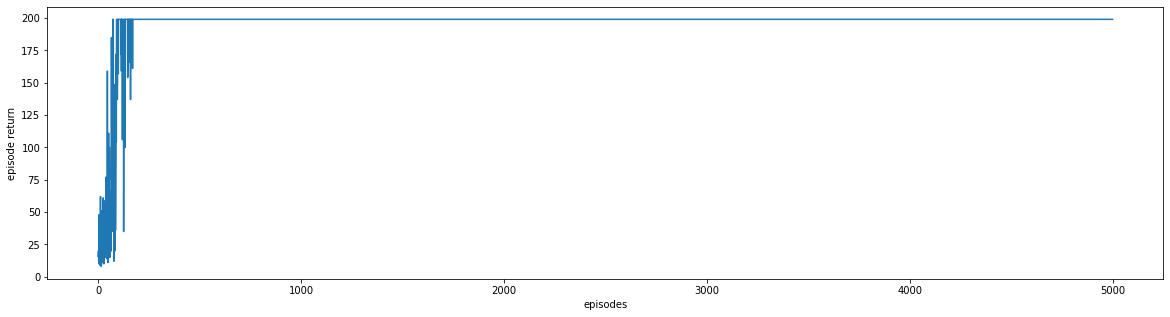

In [9]:
# *******************************************************************************************
# plot the learning curve

fig, ax = plt.subplots()
ax.plot(score)
fig.set_size_inches(20,5)
ax.set_xlabel('episodes')
ax.set_ylabel('episode return')
plt.show()

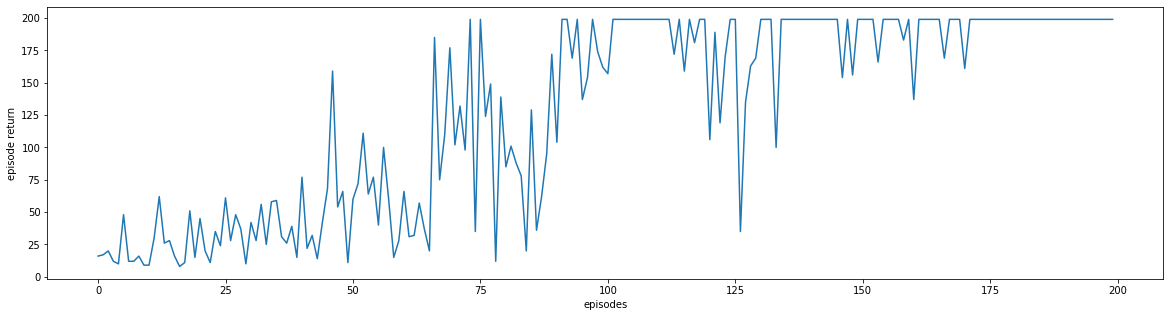

In [10]:
# *******************************************************************************************
# plot the learning curve

fig, ax = plt.subplots()
ax.plot(score[:200])
fig.set_size_inches(20,5)
ax.set_xlabel('episodes')
ax.set_ylabel('episode return')
plt.show()

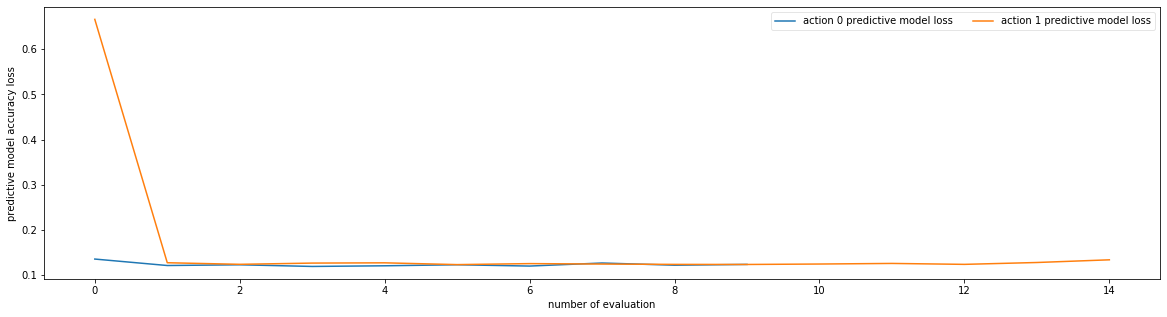

In [11]:
# *******************************************************************************************
# plot the model accuracy

fig, ax = plt.subplots()
plt.plot(agent.loss_reverse1, label="action 0 predictive model loss")
plt.plot(agent.loss_reverse2, label="action 1 predictive model loss")
fig.set_size_inches(20,5)
ax.set_xlabel('number of evaluation')
ax.set_ylabel('predictive model accuracy loss')
leg = plt.legend(loc='best', ncol=2)
leg.get_frame().set_alpha(0.5)
plt.show()

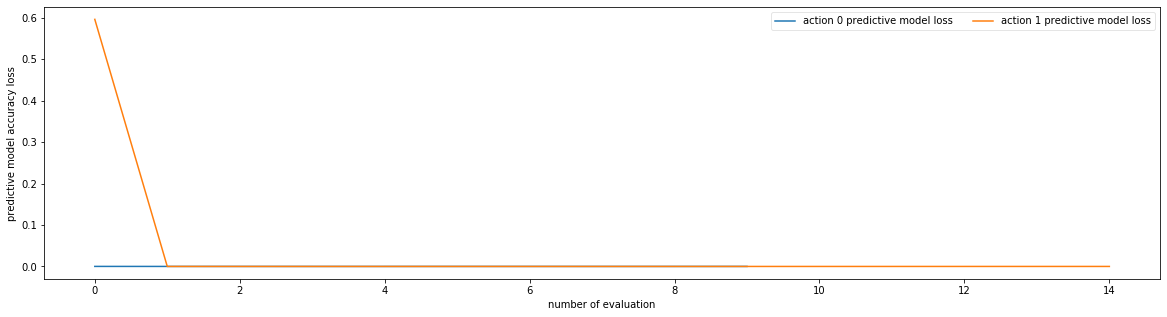

In [12]:
# *******************************************************************************************
# plot the model accuracy

fig, ax = plt.subplots()
plt.plot(agent.loss1, label="action 0 predictive model loss")
plt.plot(agent.loss2, label="action 1 predictive model loss")
fig.set_size_inches(20,5)
ax.set_xlabel('number of evaluation')
ax.set_ylabel('predictive model accuracy loss')
leg = plt.legend(loc='best', ncol=2)
leg.get_frame().set_alpha(0.5)
plt.show()

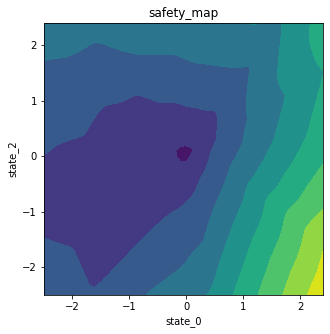

In [13]:
x = np.arange(-2.5, 2.5, 0.1)
y = np.arange(-2.500, 2.500, 0.100)
xx, yy = np.meshgrid(x, y, sparse=True)

z = np.zeros((np.shape(x)[0],np.shape(y)[0]))
for i in range(np.shape(x)[0]):
    for j in range(np.shape(y)[0]):
        c = [[x[i],0,y[j],0]]
        z[i,j] = agent.model_eval.predict(np.array(c))

fig, ax = plt.subplots()
plt.contourf(x,y,z)
fig.set_size_inches(5,5)
ax.set_xlabel('state_0')
ax.set_ylabel('state_2')
ax.set_title('safety_map')
plt.show()